# Residuals Networks and Transfer Learning

[CE477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Authors__: Ramtin Moslemi
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/ResNets_Transfer_Learning.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/ResNets_Transfer_Learning.ipynb)

---

## Notebook Objectives

In this notebook we are going to implement a simple convolutional neural network as well as CNN with residual connections. Additionally we will also take a look at Transfer Learning.



In [ ]:
! pip install torchsummary

In [ ]:
# @title setup and imports

from matplotlib import pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.cifar import CIFAR10

from torchsummary import summary

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# @title CIFAR10 dataset

norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 30215416.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# @title helper functions

def train_epoch(model, loss_fn, optimizer, dataloader=trainloader):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, 100 * train_acc


def validate_epoch(model, loss_fn, dataloader=testloader):
    model.eval()
    val_loss = 0.
    val_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss /= len(dataloader)
        val_acc /= len(dataloader.dataset)
    return val_loss, 100 * val_acc


def train_model(model, optimizer, n_epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_epoch(model, loss_fn, optimizer)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = validate_epoch(model, loss_fn)
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)
        pbar.set_description(f'Training Accuracy {train_acc:.2f}% | Validation Accuracy {val_acc:.2f}% ')
    return history


def plot_training_curves(results):
    epochs_range = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, results['train_loss'], label='Train Loss')
    plt.plot(epochs_range, results['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, results['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.yticks(range(0, 101, 10))  # Accuracy range from 0 to 100
    plt.legend()

    plt.tight_layout()
    plt.show()


def compare_results(m1_name, m1_results, m2_name, m2_results):
    epochs_range = range(1, len(m1_results['val_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, m1_results['val_loss'], label=f'{m1_name}')
    plt.plot(epochs_range, m2_results['val_loss'], label=f'{m2_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, m1_results['val_acc'], label=f'{m1_name}')
    plt.plot(epochs_range, m2_results['val_acc'], label=f'{m2_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.yticks(range(0, 101, 10))  # Accuracy range from 0 to 100
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plain Convolutional Neural Networks

Let's start by creating `BasicBlock`s for the CNN. We will create our blocks as follows:


*   Each block will have 2 convolutional layers with `kernel_size=3` and `padding=1`
*   Each convolutional layer will be followed by a batch normalization layer and a `ReLU` activation function
*   The `expansion` factor is a class attribute that indicates the channel expansion factor



In [ ]:
class BasicBlock(nn.Module):
    expansion = 1  # BasicBlock does not expand channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.relu(out)

        return out

Next we will proceed to the network itself. Using the `BasicBlock` module, we first create four blocks and double the number of channels at each one. At last we use an average pooling layer in addition to a fully connected layer to make the predictions.

The `_make_layer` method is a utility function used to create a sequence of blocks (such as `BasicBlock`s or `ResidualBlock`s) in the ResNet architecture. It handles the construction of layers, including any required downsampling to ensure dimensions match correctly for the skip connections. For residual connectionsthe input and output dimensions of a block must match, so if there is a mismatch, a sequential layer with a 1x1 convolution and batch normalization will be added to match the input to the output dimensions.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16  # CIFAR-10 starts with 16 filters

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)  # 32x32
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)  # 16x16
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)  # 8x8

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In our experiments we use the resnet architecture from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Specifically we use the architectures introduced for the CIFAR10 dataset.

In [ ]:
def resnet_cifar10(block, n):
    """
    Constructs a ResNet for CIFAR-10 with 6n+2 layers.
    Example:
    n=3 -> ResNet-20
    n=5 -> ResNet-32
    n=7 -> ResNet-44
    n=9 -> ResNet-56
    """
    return ResNet(block, [n, n, n])

Now lets create an instance of this architecture and see its parameter count.

In [ ]:
plain20 = resnet_cifar10(BasicBlock, 3).to(device)
summary(plain20, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

Finally we can train our model.

Training Accuracy 81.39% | Validation Accuracy 78.85% : 100%|██████████| 30/30 [06:58<00:00, 13.95s/it]


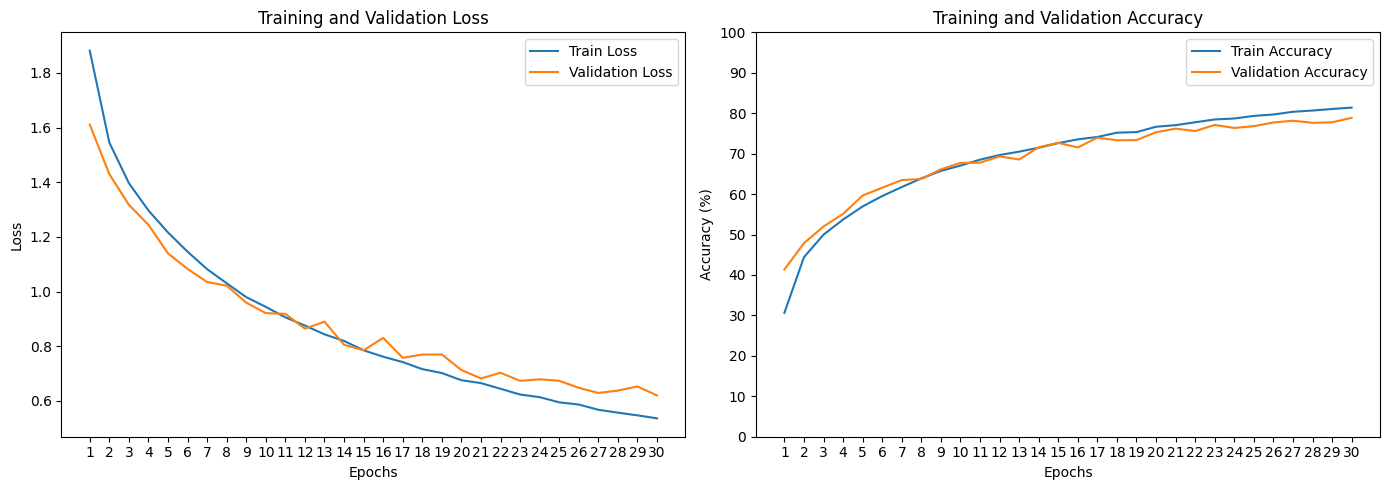

In [ ]:
if device == 'cuda':
    plain20 = torch.compile(plain20)
optim = Adam(plain20.parameters(), lr=1e-4)

p20results = train_model(plain20, optim, n_epochs=30)
plot_training_curves(p20results)

Let's move on to a larger network to get better results.

Training Accuracy 79.51% | Validation Accuracy 76.68% : 100%|██████████| 30/30 [08:16<00:00, 16.55s/it]


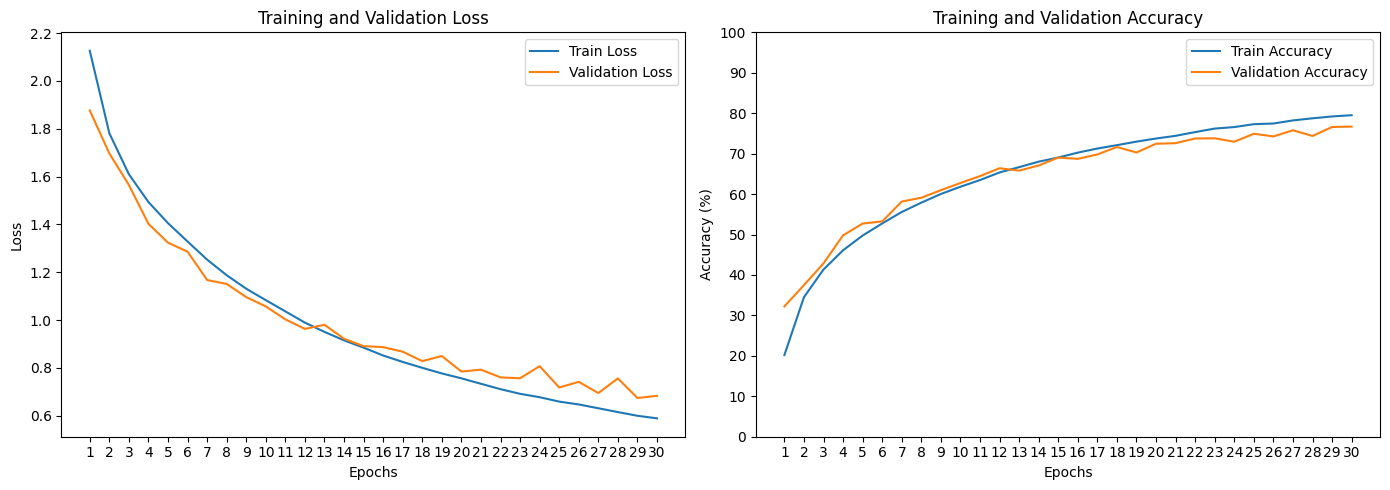

In [ ]:
plain32 = resnet_cifar10(BasicBlock, 5).to(device)
if device == 'cuda':
    plain32 = torch.compile(plain32)
optim = Adam(plain32.parameters(), lr=1e-4)

p32results = train_model(plain32, optim, n_epochs=30)
plot_training_curves(p32results)

It seems that increasing the depth of the network not only didn't help but actually made things worse!

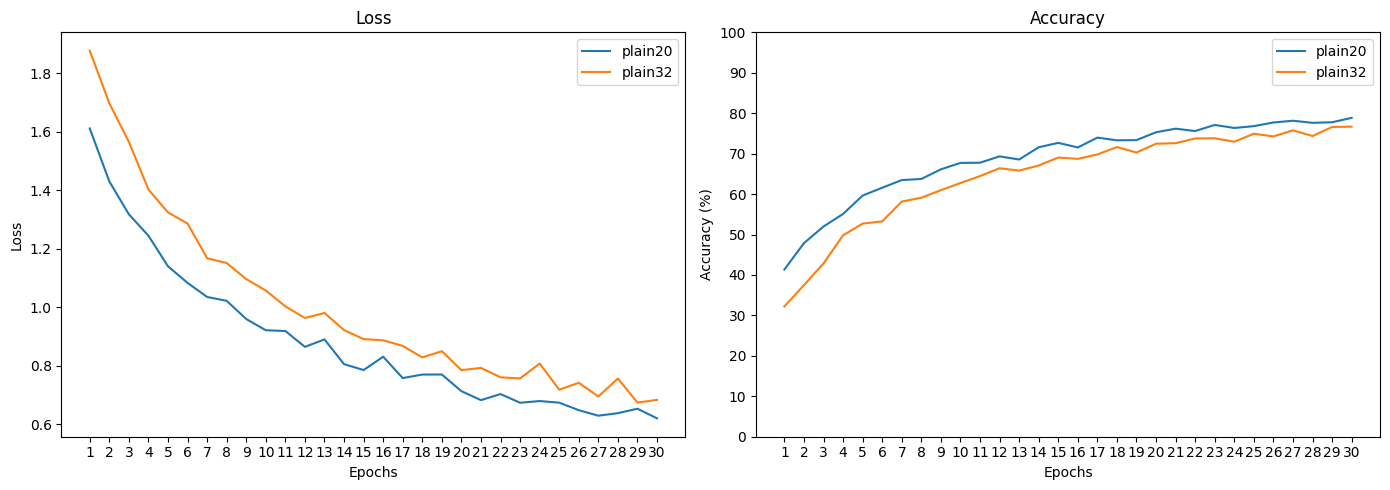

In [ ]:
compare_results('plain20', p20results, 'plain32', p32results)

# Residual Networks

In this section we are going to implement CNNs with residual connections. To do so we will first implement a `ResidualBlock` module. If the input size and output size differ, we'll add a `downsample` to overcome this issue.

In [ ]:
class ResidualBlock(nn.Module):
    expansion = 1  # BasicBlock does not expand channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

Using the `ResidualBlock` module we just defined and the `ResNet` module from the previous section, we can now build a residual network.

In [ ]:
resnet = resnet_cifar10(ResidualBlock, 3).to(device)
summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

To have a fair comparison we'll train a resnet with 32 layers to compare with the plain32 network from the last section.

Training Accuracy 85.50% | Validation Accuracy 82.07% : 100%|██████████| 30/30 [08:41<00:00, 17.37s/it]


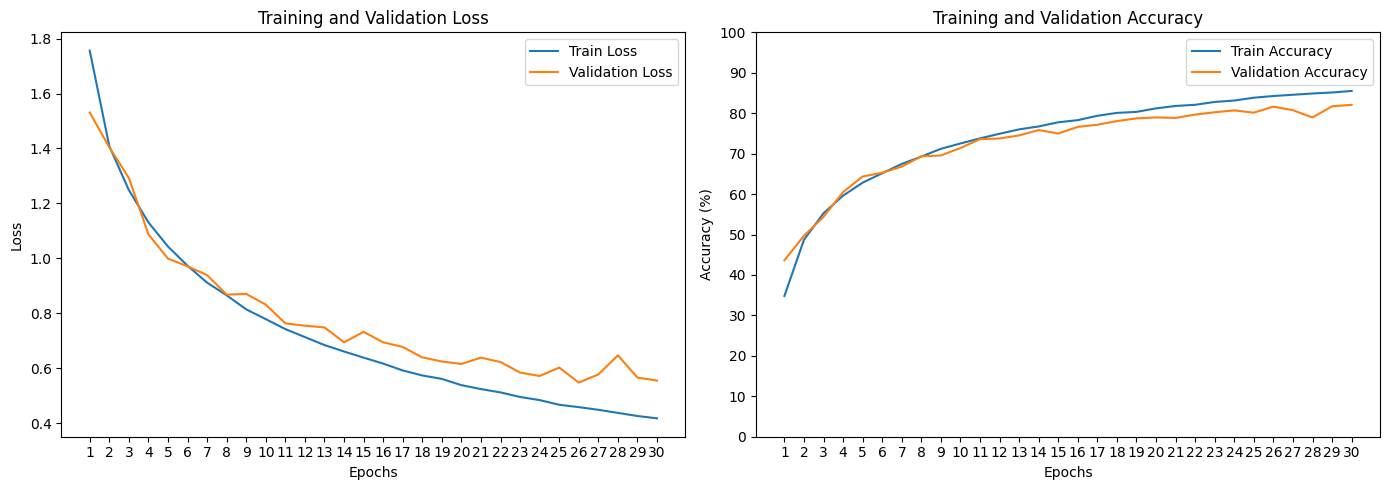

In [ ]:
resnet32 = resnet_cifar10(ResidualBlock, 5).to(device)
if device == 'cuda':
    resnet32 = torch.compile(resnet32)
optim = Adam(resnet32.parameters(), lr=1e-4)

r32results = train_model(resnet32, optim, n_epochs=30)
plot_training_curves(r32results)

As you can see both networks are identical except for the residual connections. Even for small networks such as these two you can see the improvement due to the residual connections. For larger networks with 50, 100, etc layers, this gap in performance will become wider.

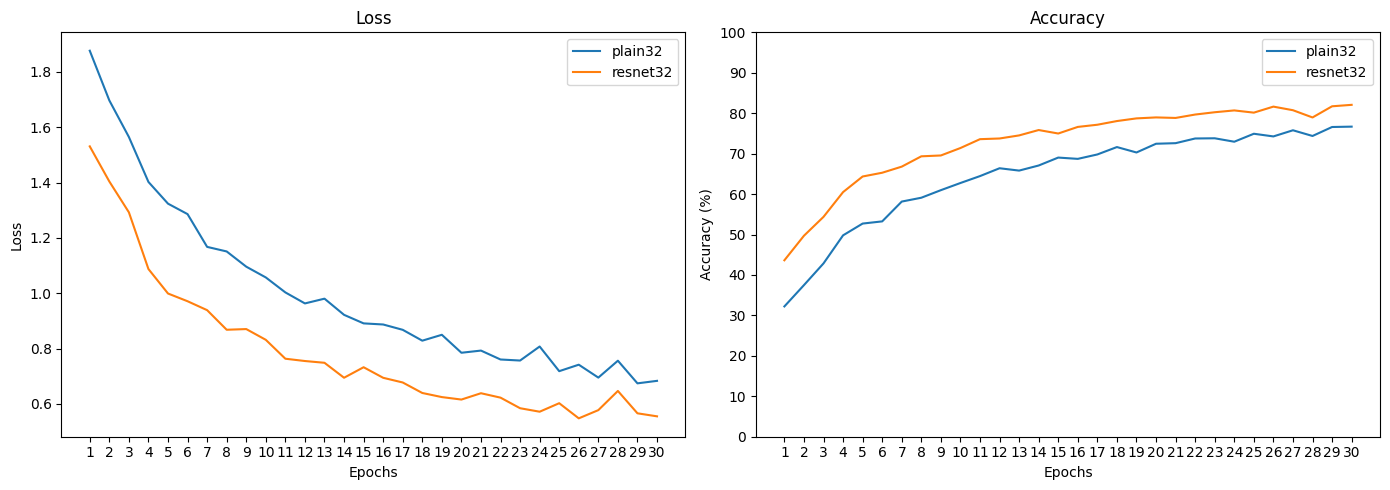

In [ ]:
compare_results('plain32', p32results, 'resnet32', r32results)

# Transfer Learning

In this section we are going to learn about transfer learning.

We use models available from torchvision. You can find a list of all [available models and pre-trained weights](https://pytorch.org/vision/stable/models.html) on torchvision.

To observe the improvement caused by transfer learning, we train the `ResNet18` model twice, once with pre-trained weights (from the ImageNet dataset) and once without pre-training.

In [ ]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)
summary(resnet18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Pre-Trained ResNet18

Training Accuracy 87.52% | Validation Accuracy 84.23% : 100%|██████████| 15/15 [06:29<00:00, 25.93s/it]


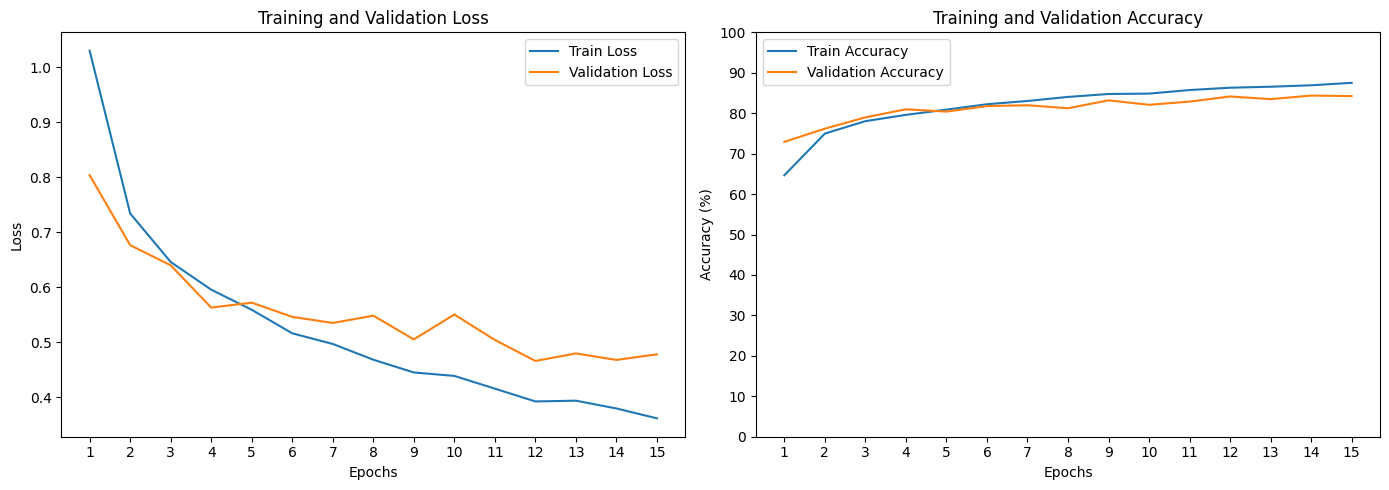

In [ ]:
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters(), lr=1e-3)

pt_results = train_model(resnet18, optim, n_epochs=15)
plot_training_curves(pt_results)

## Normal ResNet18

Training Accuracy 81.78% | Validation Accuracy 80.24% : 100%|██████████| 15/15 [06:29<00:00, 25.99s/it]


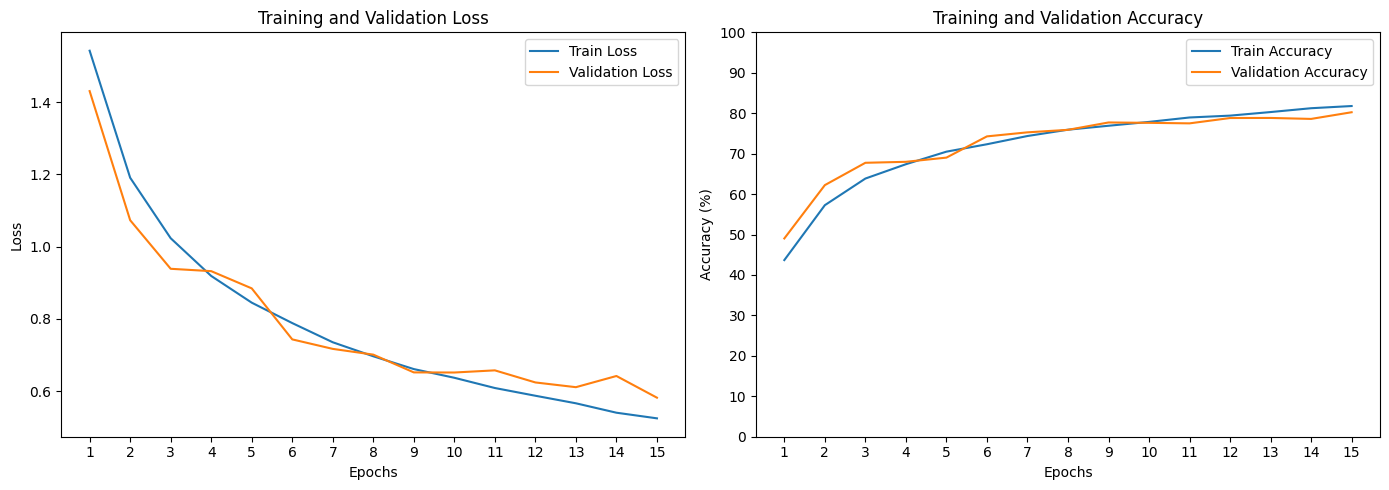

In [ ]:
resnet18 = models.resnet18(weights=None)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters(), lr=1e-3)

results = train_model(resnet18, optim, n_epochs=15)
plot_training_curves(results)

## Results

As you can see the pre-trained weights improve the accuracy significantly.

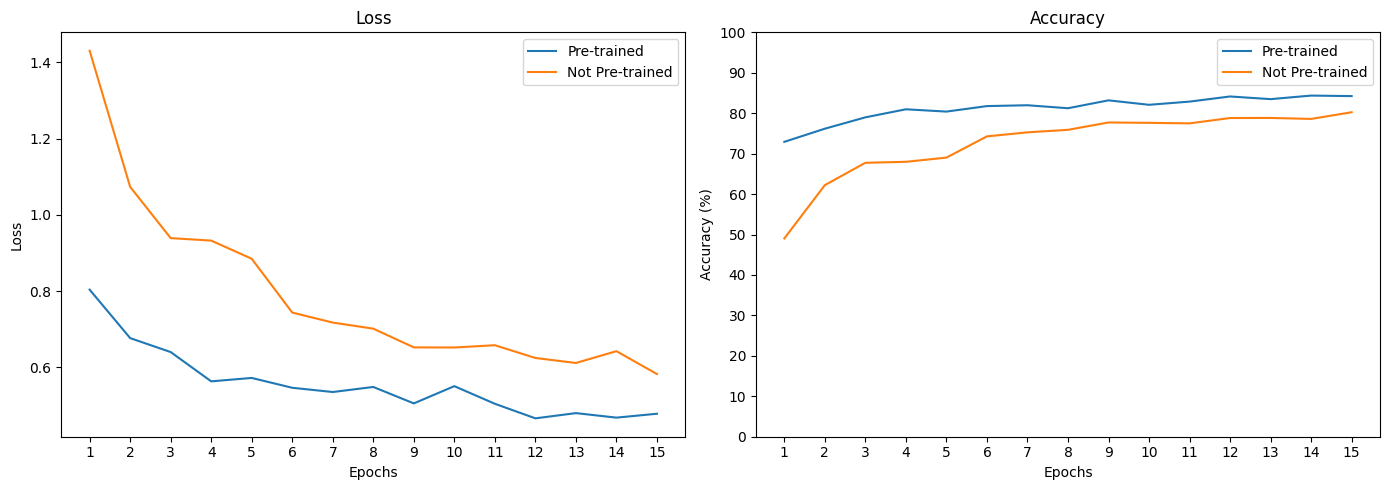

In [ ]:
compare_results('Pre-trained', pt_results, 'Not Pre-trained', results)

# Refrences

*   [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
*   [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

